In [1]:
import torch
from IPython.display import Audio
from audiodiffusion import AudioDiffusion
from diffusers import ModelMixin, ConfigMixin
from transformers import ViTImageProcessor, ViTModel
from PIL import Image

Initialize random values generator

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
generator = torch.Generator(device=device)

Load pipeline

In [3]:
audio_diffusion = AudioDiffusion(model_id='Woleek/clMusDiff')
mel = audio_diffusion.pipe.mel

Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

Initialize image feature encoder

In [4]:
class ImageEncoder(ModelMixin, ConfigMixin):
    def __init__(self, image_processor, encoder_model):
        super().__init__()
        self.processor = image_processor
        self.encoder = encoder_model
        
    def forward(self, x):
        x = self.encoder(x)
        return x
        
    @torch.no_grad()
    def encode(self, image_files):
        self.eval()
        images = [Image.open(image_file) for image_file in image_files]
        x = self.processor(images, return_tensors="pt")['pixel_values']
        y = self(x)
        y = y.last_hidden_state
        embedings = y[:,0,:] 
        return embedings

In [5]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
extractor = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

image_encoder = ImageEncoder(processor, extractor)

Encode sample image

In [6]:
encoding = torch.unsqueeze(image_encoder.encode(['samples_surv/the-scream.jpg']), axis=1).to(device)

Generate few audio examples

Seed = 6971226595359687


  0%|          | 0/50 [00:00<?, ?it/s]

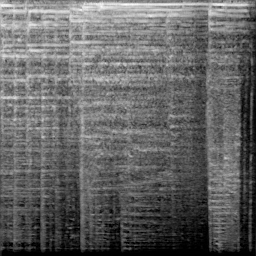

Seed = 444583530115476


  0%|          | 0/50 [00:00<?, ?it/s]

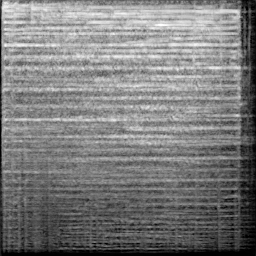

Unable to determine loop points
Seed = 2089328398520850


  0%|          | 0/50 [00:00<?, ?it/s]

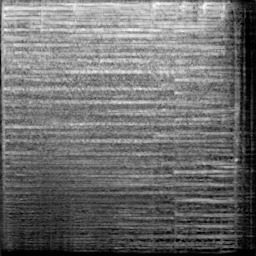

In [32]:
for _ in range(3):
    seed = generator.seed()
    print(f'Seed = {seed}')
    generator.manual_seed(seed)
    image, (sample_rate,
            audio) = audio_diffusion.generate_spectrogram_and_audio(
                generator=generator, encoding=encoding, eta=0.9)
    display(image)
    display(Audio(audio, rate=sample_rate))
    loop = AudioDiffusion.loop_it(audio, sample_rate)
    if loop is not None:
        display(Audio(loop, rate=sample_rate))
    else:
        print("Unable to determine loop points")